## This notebook investigates parameter choices for exploring jerks in the path model 
### Specifically:
1. chain length
2. SV error 
3. length of timeseries

In [135]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [136]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [137]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [138]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [139]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

#### Plot a picture of Br at the CMB at the time of jerk 9 (Python index 8, t=8880) to check that everything works

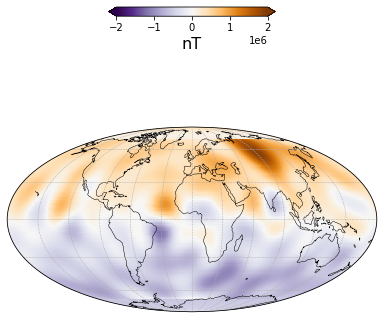

In [140]:
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[8]))

coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)

# Analysis of jerk 9

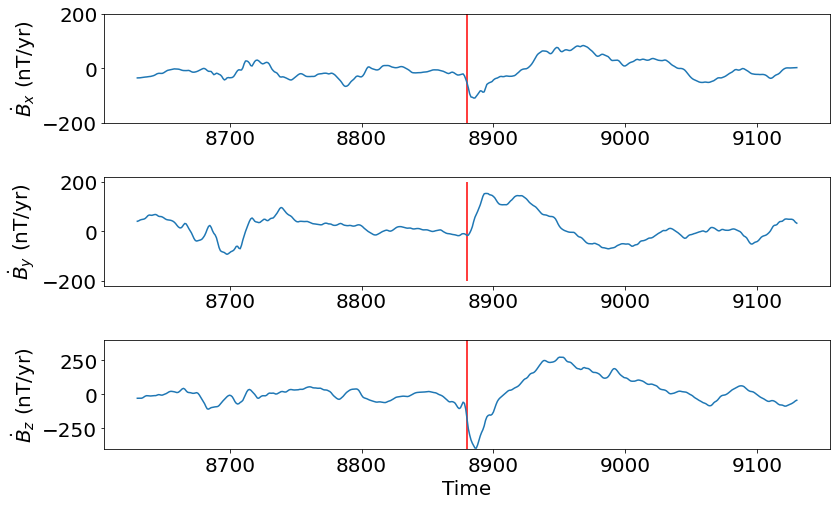

In [141]:
# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-250,jerk_times[jerk_number]+250+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
#ax2.set_ylim(-200,200)
ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

#ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time',fontsize=20)
ax3.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

#ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_SV_timeseries.pdf')

#### Run jerk finder using different chain lengths on using a 10% relative error on 500 year interval (500 data).

In [142]:
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-250,jerk_times[jerk_number]+250+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


run_components=[0]
SV_error = 10
chain_lengths = np.array([50000, 100000, 200000, 500000, 1000000, 2000000,5000000])
discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
size_jerk_data_save500cmpt0  = np.zeros(len(chain_lengths), dtype=int)
jerk_data_save500cmpt0 =np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2,len(chain_lengths)),dtype=float )


CP_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(chain_lengths),discretise_size), dtype=float )

size_jerk_data = 0
SV = Bx_dot

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2),dtype=float )

    
for i,chain in enumerate(chain_lengths):
    NSAMPLE = chain+burn_in    
    

        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() #-400
    SV_MAX = SV.max() #400
    
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save500cmpt0[0:size_jerk_data,:,i] = jerk_data[0:size_jerk_data,:]
    size_jerk_data_save500cmpt0[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [37.49599838 31.49408722 14.037817   14.19417286]
1 [37.94400024 32.0749054  14.58146858 14.79576397]
2 [37.96300125 31.43406105 14.31166935 14.51910019]
3 [37.97679901 31.32599449 14.43487644 14.53925514]
4 [37.90319824 31.47786903 14.50940704 14.56133938]
5 [37.94860077 31.43570709 14.63223934 14.67168808]
6 [37.87871933 31.4906826  14.56153107 14.54973984]


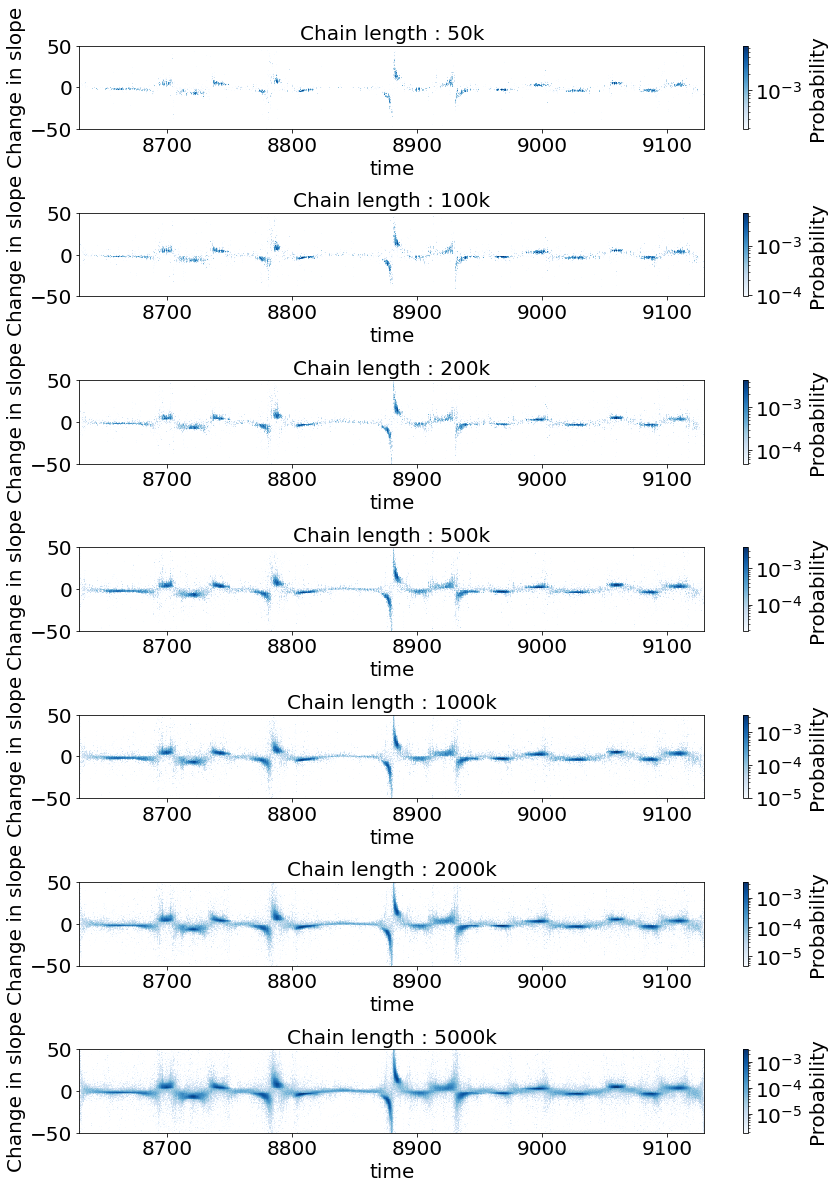

In [143]:


import matplotlib.colors as colors
ax = len(chain_lengths) * [0]
fig, ax = plt.subplots(len(chain_lengths), 1, figsize=(14,20))
for i,cl in enumerate(chain_lengths):
    data_timing = jerk_data_save500cmpt0[0:size_jerk_data_save500cmpt0[i],0,i]
    data_amplitude = jerk_data_save500cmpt0[0:size_jerk_data_save500cmpt0[i],1,i]
    counts, xedges, yedges, im = ax[i].hist2d(data_timing, data_amplitude, bins=(int(TIMES_MAX-TIMES_MIN)*2,100), range=[[TIMES_MIN,TIMES_MAX], [-50,50]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
    cb = fig.colorbar(im, ax=ax[i])
    cb.set_label("Probability", labelpad=6, size=20)
    cb.ax.tick_params(labelsize=20)
    ax[i].set_title('Chain length : {0:d}k'.format(cl//1000), fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_xlabel('time', fontsize=20)
    ax[i].set_ylabel('Change in slope', fontsize=20)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)



In [144]:
# Find jerks:

# 1. Find peaks in marginal histogram of changepoints satisfying criteria like min distance between jerks and jerk prominence, 
# 2. Find the subset of peaks for which the associated modal amplitude (from the 2d histogram) exceeds a certain threshold, label the peak a a jerk
# 3. Find the jerk width by seeing how far either side of the peak the 1d histogram drops to tau of the value at the peak.

# defaults:
# 
def find_jerks(data_timing, data_amplitude, number_time_bins, time_range, 
    number_amplitude_bins = 100, amplitude_range = [-50,50],
    jerk_min_amplitude = 1, min_distance = 4, \
    peak_prominence = 1, tau = 0.14):
    ''' 
    Function: find_jerks
    
    Returns a list of jerk attributes
    
        Parameters:
            data_timing (float, array): changepoint times
            data_amplitude: (float, array): changepoint slope changes
            number_time_bins (integer): number of bins in time
            time_range (list): start and end times
            
            Optional:
            jerk_min_amplitude (float): threshold for jerk identification
            min_distance (float): minimum distance between jerks
            prominence (float): prominence of jerks
            tau (float): threshold to characterise width of jerks
            
        Returns a list of jerk attributes in the form
            [jerk0, jerk1,...]
            where (for example) jerk0 is [jerk_time, jerk_amplitude, min_jerk_time, max_jerk_time]
            All four values are float; jerk_time is the most likely time for a jerk of amplitude jerk_amplitude, but it is uncertain with bounds given by min_jerk_time and max_jerk_time.
            
    Algorithm:
    1. Find peaks in marginal histogram of changepoints satisfying: min distance between jerks and jerk prominence. 
    2. Find the subset of peaks for which the associated slope change of maximum probability (from the 2d histogram) exceeds the threshold of jerk_min_amplitude.  See Scipy documentation for definition of prominence. 
    3. For these peaks ("jerks"), the jerk width is quantified by identifying the smallest time window that defines a drop in the 1d histogram of changepoint timing by tau on both sides. 
    If the changepoint histogram is Gaussian in shape, then 2 sigma corresponds to a drop in height of e^-2, or about 0.14. This defines then (roughly) a 95% credible interval.
    

    '''
    
    jerks_overall_info = []

    

    counts, xedges, yedges = np.histogram2d(data_timing, data_amplitude, bins=(number_time_bins,number_amplitude_bins), range=[time_range, amplitude_range])
    marginal_counts, marginal_xedges = np.histogram( data_timing, bins=number_time_bins, range=time_range)
    from scipy import signal

    peaks = signal.find_peaks(marginal_counts,distance=min_distance, prominence = peak_prominence * marginal_counts.mean() )  

    for peak_index in peaks[0]:
        jerk_info = np.zeros(4)
        index = counts[peak_index,:].argmax()  #find index corresponding to max probability
        jerk_amplitude = 0.5 * ( yedges[index] + yedges[index+1] )  #use the centre point of the bin
        if abs(jerk_amplitude) > jerk_min_amplitude:
            jerk_info[0] = 0.5 * ( marginal_xedges[peak_index] + marginal_xedges[peak_index+1] )  #use the centre point of the bin
            jerk_info[1] = jerk_amplitude

            min_jerk_time = marginal_xedges[0]
            max_jerk_time = marginal_xedges[-1]

            for i in range(peak_index,marginal_counts.shape[0]):  #count upwards in time to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    max_jerk_time = marginal_xedges[i]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the left edge of this bin.
                    break

            for i in range(peak_index,0,-1):  # count downwards to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    min_jerk_time = marginal_xedges[i+1]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the right edge of this bin.
                    break

            jerk_info[2], jerk_info[3] = min_jerk_time, max_jerk_time

            jerks_overall_info.append(jerk_info)
    return jerks_overall_info

    


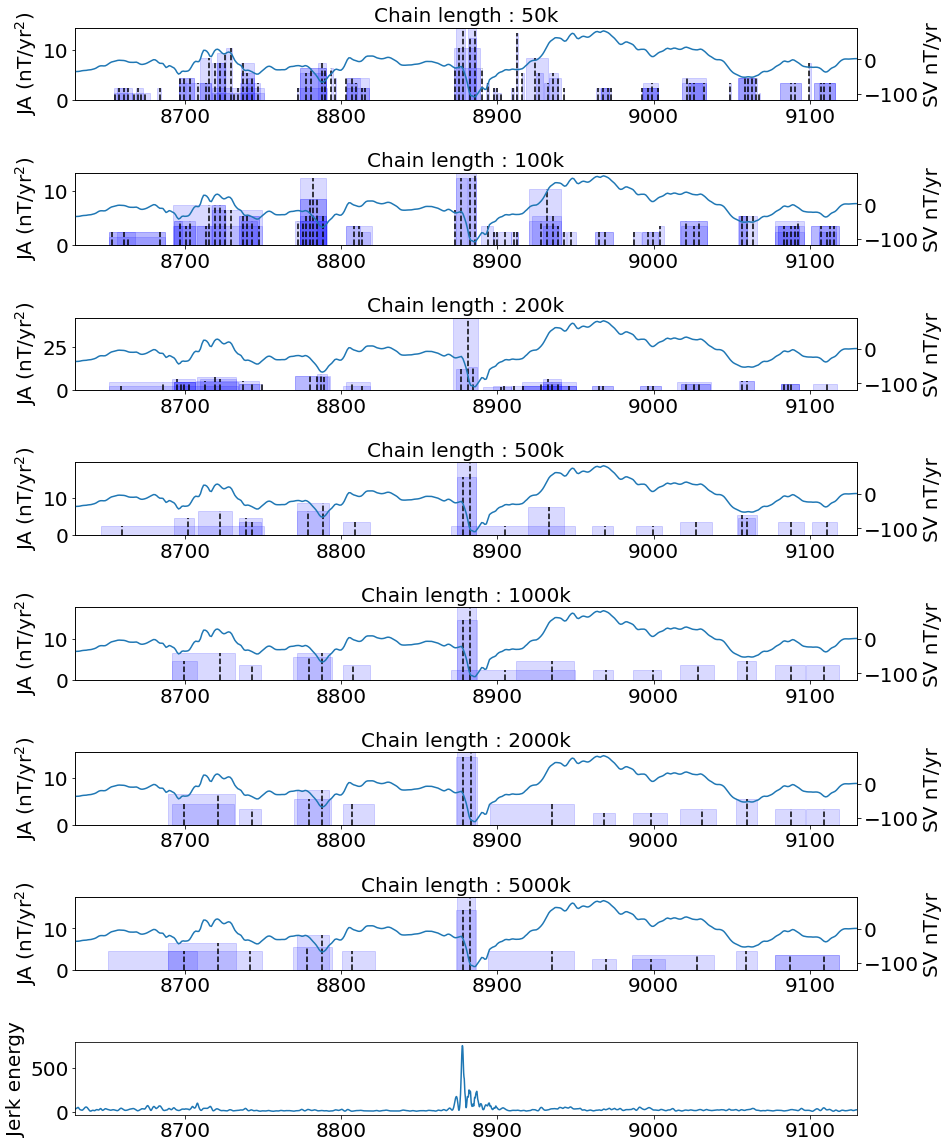

In [145]:
import matplotlib.colors as colors
ax = (len(chain_lengths)+1) * [0]
fig, ax = plt.subplots(len(chain_lengths)+1, 1, figsize=(14,20))
for i,cl in enumerate(chain_lengths):
    
    data_timing = jerk_data_save500cmpt0[0:size_jerk_data_save500cmpt0[i],0,i]
    data_amplitude = jerk_data_save500cmpt0[0:size_jerk_data_save500cmpt0[i],1,i]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)
    
    #print( len(jerks_info) )
    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[i].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[i].twinx()
    axb.tick_params(axis='y', which='major', labelsize=20)
    axb.set_ylabel('SV nT/yr',fontsize=20)
    axb.plot(TIMES, Bx_dot)
    ax[i].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[i].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[i].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[i].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')
    ax[i].set_title('Chain length : {0:d}k'.format(cl//1000), fontsize=20)

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[-1].plot(time_EJ, EJ )
ax[-1].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[-1].set_ylabel('Jerk energy',fontsize=20)
ax[-1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


In [68]:
# Number of jerks has converged to 13 by 1-2M iterations over 500yr period.


In [ ]:
## Repeat for 1000 yr period.

In [ ]:
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-500,jerk_times[jerk_number]+500+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


run_components=[0]
SV_error = 10
chain_lengths = np.array([50000, 100000, 200000, 500000, 1000000, 2000000,5000000])
discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
size_jerk_data_save1000cmpt0  = np.zeros(len(chain_lengths), dtype=int)
jerk_data_save1000cmpt0 =np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2,len(chain_lengths)),dtype=float )


CP_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(chain_lengths),discretise_size), dtype=float )

size_jerk_data = 0
SV = Bx_dot

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2),dtype=float )

    
for i,chain in enumerate(chain_lengths):
    NSAMPLE = chain+burn_in    
    

        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() #-400
    SV_MAX = SV.max() #400
    
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save1000cmpt0[0:size_jerk_data,:,i] = jerk_data[0:size_jerk_data,:]
    size_jerk_data_save1000cmpt0[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

In [ ]:


import matplotlib.colors as colors
ax = len(chain_lengths) * [0]
fig, ax = plt.subplots(len(chain_lengths), 1, figsize=(14,20))
for i,cl in enumerate(chain_lengths):
    data_timing = jerk_data_save1000cmpt0[0:size_jerk_data_save1000cmpt0[i],0,i]
    data_amplitude = jerk_data_save1000cmpt0[0:size_jerk_data_save1000cmpt0[i],1,i]
    counts, xedges, yedges, im = ax[i].hist2d(data_timing, data_amplitude, bins=(int(TIMES_MAX-TIMES_MIN)*2,100), range=[[TIMES_MIN,TIMES_MAX], [-50,50]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
    cb = fig.colorbar(im, ax=ax[i])
    cb.set_label("Probability", labelpad=6, size=20)
    cb.ax.tick_params(labelsize=20)
    ax[i].set_title('Chain length : {0:d}k'.format(cl//1000), fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_xlabel('time', fontsize=20)
    ax[i].set_ylabel('Change in slope', fontsize=20)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)



In [ ]:
import matplotlib.colors as colors
ax = (len(chain_lengths)+1) * [0]
fig, ax = plt.subplots(len(chain_lengths)+1, 1, figsize=(14,20))
for i,cl in enumerate(chain_lengths):
    
    data_timing = jerk_data_save500cmpt0[0:size_jerk_data_save1000cmpt0[i],0,i]
    data_amplitude = jerk_data_save500cmpt0[0:size_jerk_data_save1000cmpt0[i],1,i]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)
    
    #print( len(jerks_info) )
    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[i].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[i].twinx()
    axb.tick_params(axis='y', which='major', labelsize=20)
    axb.set_ylabel('SV nT/yr',fontsize=20)
    axb.plot(TIMES, Bx_dot)
    ax[i].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[i].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[i].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[i].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')
    ax[i].set_title('Chain length : {0:d}k'.format(cl//1000), fontsize=20)

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[-1].plot(time_EJ, EJ )
ax[-1].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[-1].set_ylabel('Jerk energy',fontsize=20)
ax[-1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


## Run jerk finder using different relative error budgets on 400 year interval (400 data).
#### NB I don't think there is much need for this, if we have an objective means of choosing the error budget. Nevertheless, 10% error seems OK.

In [51]:
run_components=[0]
SV_error = [5,10,15,20]
chain_lengths = 200000
discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(SV_error),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(SV_error),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(SV_error),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(SV_error),time_intervals_nbins), dtype=float )
size_jerk_data_save  = np.zeros( len(SV_error), dtype=int)

CP_hist_save = np.zeros( (len(SV_error),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(SV_error),discretise_size), dtype=float )
NSAMPLE = chain_lengths+burn_in    

size_jerk_data = 0
SV = Bx_dot

jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*chain_lengths//THIN,2,len(SV_error)),dtype=float )

    
for i,err in enumerate(SV_error):
    
    jerk_data = np.zeros( ((K_MAX - K_MIN+1)*chain_lengths//THIN,2),dtype=float )

        
    delta_SV = err * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[0:size_jerk_data,:,i] = jerk_data[0:size_jerk_data,:]
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [21.27000046 16.12980652  2.48704362  2.52453566]
1 [36.22000122 30.69256401  3.90480733  3.96195078]
2 [45.67900085 41.90081787  5.19449568  5.2696743 ]
3 [45.11199951 45.76128769  5.08726978  5.15189934]


<Figure size 432x288 with 0 Axes>

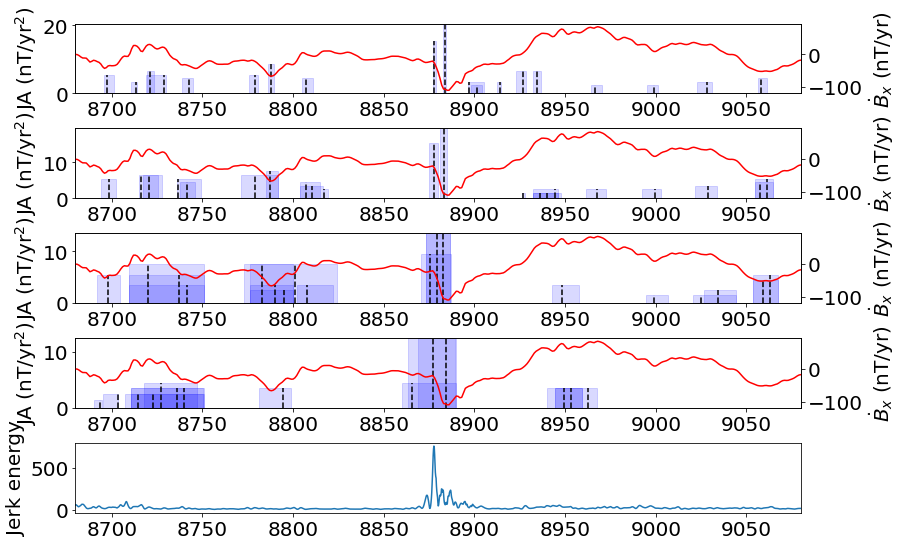

In [56]:
plt.figure()
ax=[0,1,2,3,4]
f, (ax[0], ax[1],ax[2],ax[3],ax[4]) = plt.subplots(5, 1, figsize=(13,9) )

for cmpt in [0,1,2,3]:
    data_timing = jerk_data_save[0:size_jerk_data_save[0],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                       time_range, amplitude_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    
    axb.plot(TIMES,Bx_dot,'r')
    axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[4].plot(time_EJ, EJ )
ax[4].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[4].set_ylabel('Jerk energy',fontsize=20)
ax[4].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


In [ ]:
# Either 5 or 10% error seem OK
# Note that as the error budget goes up, the jerk amplitude comes down.

## Increase the timeseries length. What happens?

In [ ]:
run_components=[0]
SV_error = 10
chain_lengths = np.array([50000, 100000, 200000, 1000000, 2000000])
discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=float )
size_jerk_data_save  = np.zeros(len(chain_lengths), dtype=int)

CP_hist_save = np.zeros( (len(chain_lengths),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(chain_lengths),discretise_size), dtype=float )

size_jerk_data = 0
SV = Bx_dot

jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2,len(chain_lengths)),dtype=float )
jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(chain_lengths.max())//THIN,2),dtype=float )

    
for i,chain in enumerate(chain_lengths):
    NSAMPLE = chain+burn_in    
    

        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[0:size_jerk_data,:,i] = jerk_data[0:size_jerk_data,:]
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

In [55]:
# Redo the 400 year calculation:

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    
    SV_MIN = SV.min() # -400
    SV_MAX = SV.max() # 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [38.70019913 34.01292038 14.60222054 14.65035534]
1 [39.12120056 34.11878586 14.13695621 14.18519878]
2 [31.85580063 41.07737732 10.88430119 10.92190552]


Component 0 has 13 jerks
Component 1 has 11 jerks
Component 2 has 8 jerks


<Figure size 432x288 with 0 Axes>

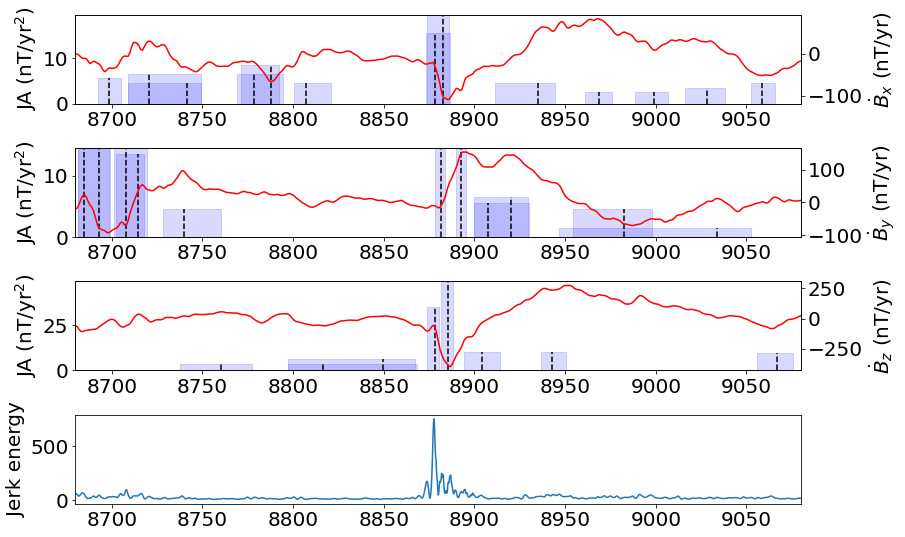

In [56]:
jerk_data_save400 = jerk_data_save
size_jerk_data_save400 = size_jerk_data_save
plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info400 = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info400)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info400:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')
    print('Component {0:d} has {1:d} jerks'.format(cmpt, len(jerks_info400)))

    
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'400yrs.pdf')


In [12]:
# Now 800 years calculation:

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-400,jerk_times[jerk_number]+400+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() # -400
    SV_MAX = SV.max() # 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [36.70539856 25.53461075 13.82430267 13.87274933]
1 [36.39680099 21.20657349 13.5489397  13.59815407]
2 [31.5904007  28.77451706 11.33040333 11.36954975]


Component 0 has 25 jerks
Component 1 has 19 jerks
Component 2 has 23 jerks


<Figure size 432x288 with 0 Axes>

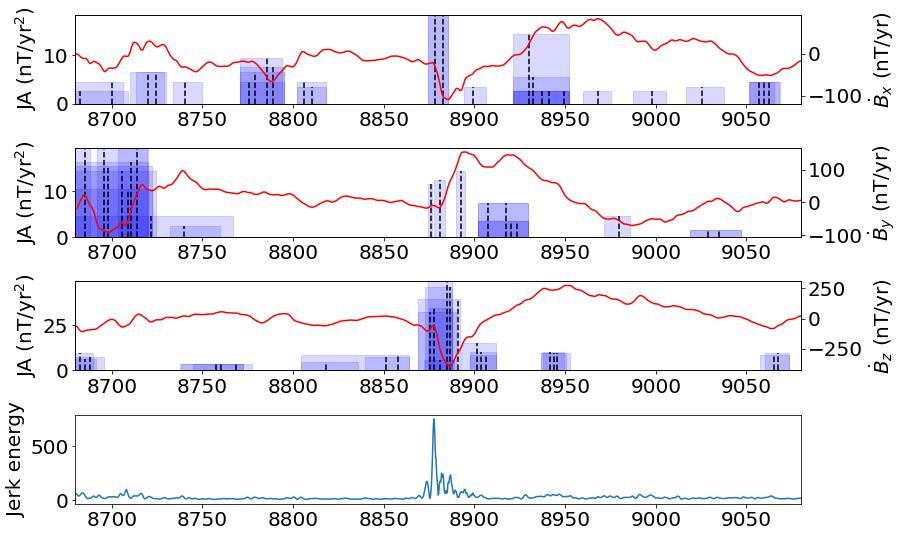

In [57]:
jerk_data_save800 = jerk_data_save
size_jerk_data_save800 = size_jerk_data_save

plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save800[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save800[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info800 = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info800)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info800:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')

    print('Component {0:d} has {1:d} jerks'.format(cmpt, len(jerks_info800)))
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'800yrs.pdf')


In [86]:
# Now 2000 years calculation:

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-1000,jerk_times[jerk_number]+1000+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [30.82480049 10.18904877  4.0454607   4.05222702]
1 [31.23080063  9.48364353  4.6430583   4.65369225]
2 [27.77179909 17.2845211   8.61606407  8.64403057]


Component 0 has 166 jerks
Component 1 has 165 jerks
Component 2 has 149 jerks


<Figure size 432x288 with 0 Axes>

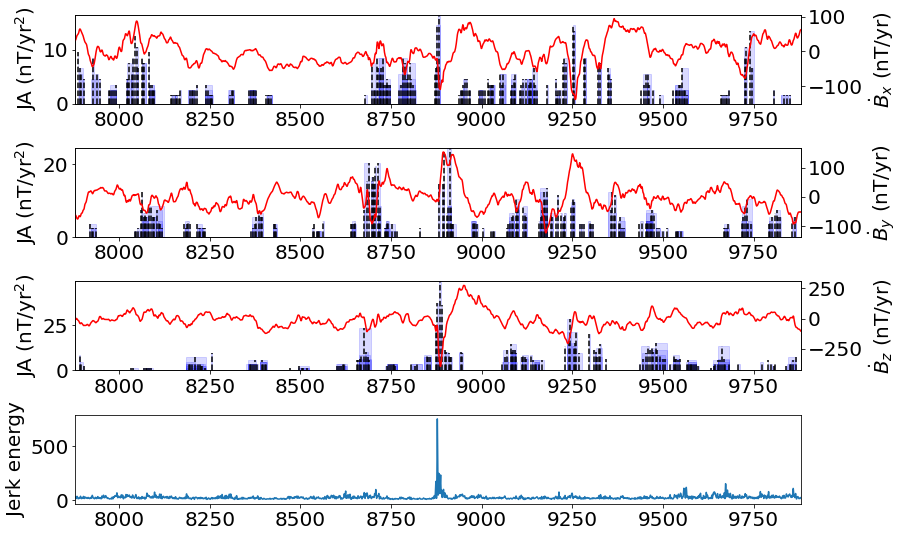

In [87]:
plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info2000 = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                       time_range, amplitude_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info2000)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info2000:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')

    print('Component {0:d} has {1:d} jerks'.format(cmpt, len(jerks_info2000)))
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'2000yrs.pdf')


#### Compare 400, 800 yr calculation for same 400 yr time period centred on 8880

In [61]:
for jerk in jerks_info800:
    if abs(jerk[0] -8880) < 200:
        print( jerk )

[8682.25    9.5  8680.   8689.5 ]
[8.68525e+03 6.50000e+00 8.68000e+03 8.69150e+03]
[8.68775e+03 7.50000e+00 8.68000e+03 8.69550e+03]
[ 8.75775e+03 -3.50000e+00  8.74500e+03  8.77250e+03]
[ 8.76025e+03 -3.50000e+00  8.73800e+03  8.77250e+03]
[ 8.76875e+03 -3.50000e+00  8.73750e+03  8.77750e+03]
[8.81825e+03 4.50000e+00 8.80450e+03 8.83600e+03]
[ 8.85125e+03 -7.50000e+00  8.83950e+03  8.86400e+03]
[ 8.85775e+03 -8.50000e+00  8.80450e+03  8.86400e+03]
[8875.25  -32.5  8869.   8890.  ]
[8877.75  -34.5  8875.   8887.5 ]
[ 8.88125e+03 -5.50000e+00  8.87200e+03  8.88850e+03]
[8884.75   49.5  8874.5  8887.5 ]
[8886.75   46.5  8872.5  8887.5 ]
[8890.75   39.5  8869.   8892.  ]
[8901.25  -15.5  8892.5  8912.  ]
[8903.75  -10.5  8897.5  8912.  ]
[ 8.90625e+03 -8.50000e+00  8.89750e+03  8.91200e+03]
[8941.75  -10.5  8938.   8949.5 ]
[8943.75   -9.5  8936.5  8950.5 ]
[8945.75   -9.5  8936.5  8952.5 ]
[9.06525e+03 8.50000e+00 9.05750e+03 9.07350e+03]
[9067.25    9.5  9060.   9073.5 ]


In [60]:
for jerk in jerks_info400:
    if abs(jerk[0] -8880) < 200:
        print( jerk )

[ 8.76025e+03 -3.50000e+00  8.73750e+03  8.77750e+03]
[8.81675e+03 3.50000e+00 8.79700e+03 8.86850e+03]
[ 8.84975e+03 -6.50000e+00  8.79700e+03  8.86700e+03]
[8878.25  -35.5  8874.   8880.5 ]
[8885.25   49.5  8881.5  8888.  ]
[8904.25  -10.5  8894.5  8914.  ]
[8942.75  -10.5  8936.5  8950.5 ]
[9066.75    9.5  9056.   9075.5 ]


Text(0, 0.5, 'Change in slope')

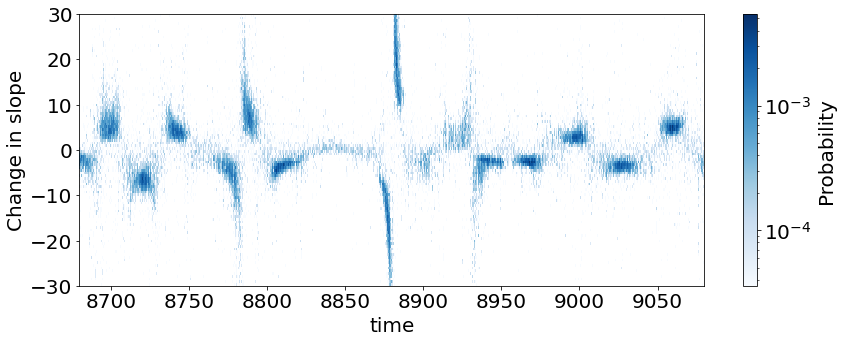

In [16]:
data_timing = jerk_data_save[0:size_jerk_data_save400[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save400[0],1,0]

import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(14,5))
counts, xedges, yedges, im = ax.hist2d(data_timing, data_amplitude, bins=(int(400)*2,100), range=[[8880-200,8880+200], [-30,30]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)


Text(0, 0.5, 'Change in slope')

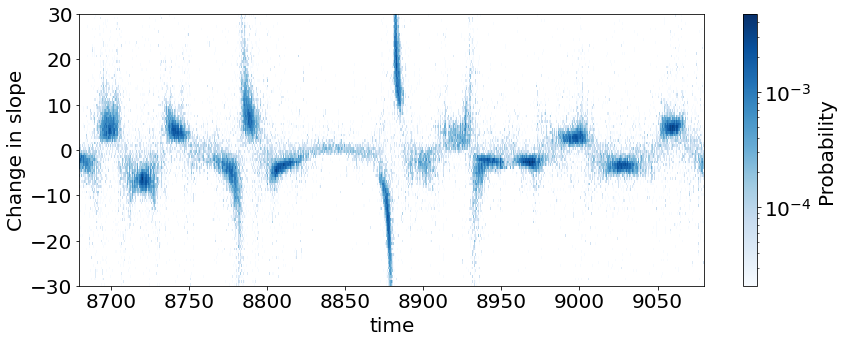

In [17]:
data_timing = jerk_data_save[0:size_jerk_data_save800[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save800[0],1,0]

import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(14,5))
counts, xedges, yedges, im = ax.hist2d(data_timing, data_amplitude, bins=(int(400)*2,100), range=[[8880-200,8880+200], [-30,30]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)


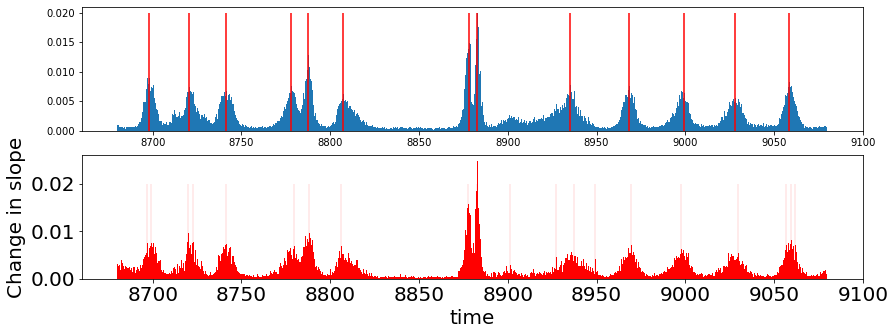

In [75]:
data_timing = jerk_data_save[0:size_jerk_data_save400[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save400[0],1,0]

import matplotlib.colors as colors
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(14,5))
counts, xedges, im = ax1.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True)
marginal_counts, marginal_xedges = np.histogram( jerk_data_save400[0:size_jerk_data_save400[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax1.vlines(i,0,0.02,'r')
    
    

data_timing = jerk_data_save800[0:size_jerk_data_save800[0],0,0]
data_amplitude = jerk_data_save800[0:size_jerk_data_save800[0],1,0]
counts, xedges, im = ax2.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True,color='red')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('Change in slope', fontsize=20)

marginal_counts, marginal_xedges = np.histogram( jerk_data_save800[0:size_jerk_data_save800[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax2.vlines(i,0,0.02,'r',alpha=0.1)

In [70]:
cmpt = 0
data_timing = jerk_data_save800[0:size_jerk_data_save800[cmpt],0,cmpt]
data_amplitude = jerk_data_save800[0:size_jerk_data_save800[cmpt],1,cmpt]
number_time_bins = 800
number_amplitude_bins = 100
time_range = [8880-200,8880+200]
amplitude_range = [-50,50]
jerks_info800 = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)



In [81]:
marginal_counts, marginal_xedges = np.histogram( jerk_data_save800[0:size_jerk_data_save800[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
signal.peak_widths(marginal_counts, peaks[0])

(array([ 1.39849624, 15.24482759,  4.96640798,  1.83261588, 11.67044962,
         2.31074977, 13.43581081, 10.25045081,  4.69545538,  3.91382291,
         3.08562451,  1.25821332, 16.48743767,  1.07608696, 13.51772031,
        14.42120853, 14.74078947,  1.61347518, 11.10724324,  1.70181762]),
 array([ 498.5,  362. ,  438. ,  540.5,  329. ,  420. ,  409.5,  305.5,
         877.5, 1042.5,  135. ,  248.5,  252.5,  212.5,  308.5,  279. ,
         247.5,  491. ,  357. ,  457.5]),
 array([ 33.10150376,  29.26666667,  77.99090909,  83.55025126,
        116.09243697, 197.42073171, 208.06418919, 248.63664596,
        393.22351695, 402.76126126, 441.3880597 , 493.34405941,
        502.28787879, 537.5       , 569.42672414, 629.375     ,
        687.18421053, 751.88652482, 750.75675676, 763.39140271]),
 array([ 34.5       ,  44.51149425,  82.95731707,  85.38286713,
        127.7628866 , 199.73148148, 221.5       , 258.88709677,
        397.91897233, 406.67508418, 444.47368421, 494.60227273,
      

In [73]:
for jerk in jerks_info400:
    if abs(jerk[0] -8880) < 200:
        print( jerk )
print('')
for jerk in jerks_info800:
    if abs(jerk[0] -8880) < 200:
        print( jerk )
print( len(jerks_info800))

[ 8.76025e+03 -3.50000e+00  8.73750e+03  8.77750e+03]
[8.81675e+03 3.50000e+00 8.79700e+03 8.86850e+03]
[ 8.84975e+03 -6.50000e+00  8.79700e+03  8.86700e+03]
[8878.25  -35.5  8874.   8880.5 ]
[8885.25   49.5  8881.5  8888.  ]
[8904.25  -10.5  8894.5  8914.  ]
[8942.75  -10.5  8936.5  8950.5 ]
[9066.75    9.5  9056.   9075.5 ]

[8.69725e+03 3.50000e+00 8.68000e+03 8.70850e+03]
[8.69925e+03 4.50000e+00 8.68000e+03 8.70850e+03]
[ 8.72025e+03 -6.50000e+00  8.71500e+03  8.72900e+03]
[ 8.72275e+03 -6.50000e+00  8.71350e+03  8.72900e+03]
[8.74175e+03 4.50000e+00 8.73400e+03 8.75100e+03]
[ 8.77975e+03 -6.50000e+00  8.76600e+03  8.79600e+03]
[8.78825e+03 6.50000e+00 8.77100e+03 8.79400e+03]
[ 8.80625e+03 -4.50000e+00  8.80100e+03  8.82150e+03]
[8877.75  -17.5  8873.5  8886.  ]
[8882.75   18.5  8874.5  8885.5 ]
[ 8.90175e+03 -2.50000e+00  8.89400e+03  8.90850e+03]
[8.92725e+03 5.50000e+00 8.91600e+03 8.95250e+03]
[ 8.93725e+03 -3.50000e+00  8.92150e+03  8.95200e+03]
[ 8.94925e+03 -2.50000e+00  8

In [82]:
# Now 800 years calculation with 2M

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-400,jerk_times[jerk_number]+400+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save8002M =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save8002M  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() # -400
    SV_MAX = SV.max() # 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save8002M[:,:,i] = jerk_data
    size_jerk_data_save8002M[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [36.71749878 25.70148087 13.89546108 13.93522358]
1 [36.44540024 21.12812996 13.58876991 13.62652111]
2 [31.62899971 28.86031342 11.36944962 11.40013409]


In [85]:
# Now 800 years calculation with 5M

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-400,jerk_times[jerk_number]+400+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save8005M =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save8005M  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = SV.min() # -400
    SV_MAX = SV.max() # 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save8005M[:,:,i] = jerk_data
    size_jerk_data_save8005M[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [36.71749878 25.70148087 13.89546108 13.93522358]
1 [36.44540024 21.12812996 13.58876991 13.62652111]
2 [31.62899971 28.86031342 11.36944962 11.40013409]


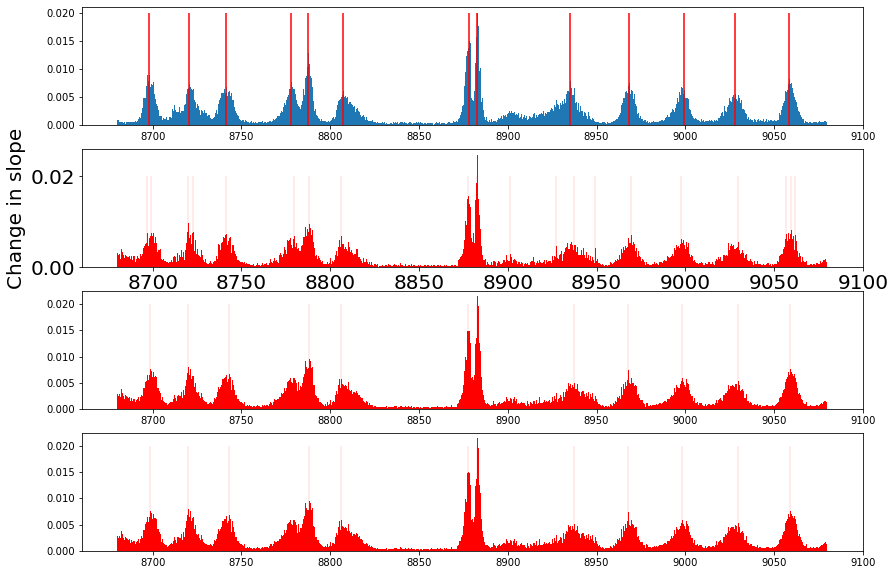

In [89]:
data_timing = jerk_data_save[0:size_jerk_data_save400[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save400[0],1,0]

import matplotlib.colors as colors
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(14,10))
counts, xedges, im = ax1.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True)
marginal_counts, marginal_xedges = np.histogram( jerk_data_save400[0:size_jerk_data_save400[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax1.vlines(i,0,0.02,'r')
    
    
data_timing = jerk_data_save800[0:size_jerk_data_save800[0],0,0]
data_amplitude = jerk_data_save800[0:size_jerk_data_save800[0],1,0]
counts, xedges, im = ax2.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True,color='red')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('Change in slope', fontsize=20)

marginal_counts, marginal_xedges = np.histogram( jerk_data_save800[0:size_jerk_data_save800[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax2.vlines(i,0,0.02,'r',alpha=0.1)
    

data_timing = jerk_data_save8002M[0:size_jerk_data_save8002M[0],0,0]
data_amplitude = jerk_data_save8002M[0:size_jerk_data_save8002M[0],1,0]
counts, xedges, im = ax3.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True,color='red')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('Change in slope', fontsize=20)

marginal_counts, marginal_xedges = np.histogram( jerk_data_save8002M[0:size_jerk_data_save8002M[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax3.vlines(i,0,0.02,'r',alpha=0.1)
    
data_timing = jerk_data_save8005M[0:size_jerk_data_save8005M[0],0,0]
data_amplitude = jerk_data_save8005M[0:size_jerk_data_save8005M[0],1,0]
counts, xedges, im = ax4.hist(data_timing, bins=(int(400)*2), range=[8880-200,8880+200],density=True,color='red')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('time', fontsize=20)
ax2.set_ylabel('Change in slope', fontsize=20)
marginal_counts, marginal_xedges = np.histogram( jerk_data_save8005M[0:size_jerk_data_save8005M[0],0,0], \
    bins=800, range=[8880-200,8880+200])
from scipy import signal
peaks = signal.find_peaks(marginal_counts,distance=4, prominence = 1 * marginal_counts.mean() )  
for i in marginal_xedges[peaks[0]]:
    ax4.vlines(i,0,0.02,'r',alpha=0.1)

In [112]:
# Redo the 400 year calculation at comparable chain length to 2000yr calculation.
# Presumably we need a chain 5 times as short?

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000//5+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [36.22000122 30.69256401  3.90480733  3.96195078]


Text(0, 0.5, 'Change in slope')

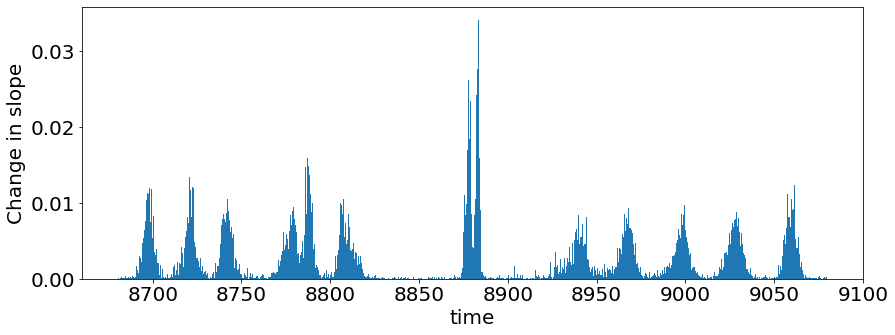

In [113]:
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]

import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(14,5))
counts, xedges, im = ax.hist(data_timing, bins=(int(8880+200-(8880-200))*2), range=[8880-200,8880+200],density=True, \
                                        )


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)


In [114]:
# Answer: 400 years calculation seems much better converged compared with 2000yrs calculation with a chain length of 5 times the length,


In [115]:
# Try increasing the chain length for 2000yrs - does this make a difference?
# (i.e. is the calculation converged at 1M iterations?)

# Now 2000 years calculation:

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-1000,jerk_times[jerk_number]+1000+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 10000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [30.8721981  10.20718098  4.10402346  4.09331751]
